In [25]:
import os
import random
import paddle
import numpy as np
from paddle.nn import Linear
import paddle.nn.functional as F
from matplotlib import pyplot as plt

In [14]:
def load_data():
    # 从文件导入数据
    datafile = './dataset/housing.data'
    data = np.fromfile(datafile, sep=' ', dtype=np.float32)

    feature_num = 14

    # Reshape原始数据[:, 14]
    data = data.reshape([data.shape[0] // feature_num, feature_num])

    # 将原数据集拆分成训练集和测试集
    # 这里使用80%的数据做训练，20%的数据做测试
    # 测试集和训练集必须是没有交集的
    ratio = 0.8
    offset = int(data.shape[0] * ratio)
    training_data = data[:offset]

    # 计算train数据集的最大值，最小值，平均值
    maximums, minimums, avgs = training_data.max(axis=0), training_data.min(axis=0),                                  training_data.sum(axis=0) / training_data.shape[0]
    
    # 记录数据的归一化参数，在预测时对数据做归一化
    global max_values
    global min_values
    global avg_values
    max_values = maximums
    min_values = minimums
    avg_values = avgs

    # 对数据进行归一化处理
    for i in range(feature_num):
        data[:, i] = (data[:, i] - avgs[i]) / (maximums[i] - minimums[i])

    # 训练集和测试集的划分比例
    training_data = data[:offset]
    test_data = data[offset:]
    
    return training_data, test_data

In [9]:
class Regressor(paddle.nn.Layer):
    # self代表类的实例自身
    def __init__(self):
        # 初始化父类中的一些参数
        super(Regressor, self).__init__()
        
        # 定义两层全连接层，输入维度是13，输出维度是1
        self.fc1 = Linear(in_features=13, out_features=13)
        self.fc2 = Linear(in_features=13, out_features=1)
    
    # 网络的前向计算
    def forward(self, inputs):
        x = self.fc1(inputs)
        x = self.fc2(x)
        return x

In [26]:
def train():
    # 声明定义好的线性回归模型
    model = Regressor()
    # 开启模型训练模式
    model.train()
    # 加载数据
    training_data, test_data = load_data()
    # 定义优化算法，使用随机梯度下降SGD
    # 学习率设置为0.01
    opt = paddle.optimizer.SGD(learning_rate=0.005, parameters=model.parameters())

    EPOCH_NUM = 50   # 设置外层循环次数
    BATCH_SIZE = 10  # 设置batch大小
    
    losses = []

    # 定义外层循环
    for epoch_id in range(EPOCH_NUM):
        # 在每轮迭代开始之前，将训练数据的顺序随机的打乱
        np.random.shuffle(training_data)
        # 将训练数据进行拆分，每个batch包含10条数据
        mini_batches = [training_data[k:k+BATCH_SIZE] for k in range(0, len(training_data), BATCH_SIZE)]
        # 定义内层循环
        for iter_id, mini_batch in enumerate(mini_batches):
            x = np.array(mini_batch[:, :-1]) # 获得当前批次训练数据
            y = np.array(mini_batch[:, -1:]) # 获得当前批次训练标签（真实房价）
            # 将numpy数据转为飞桨动态图tensor形式
            house_features = paddle.to_tensor(x)
            prices = paddle.to_tensor(y)
            
            # 前向计算
            predicts = model(house_features)
            
            # 计算损失
            loss = F.square_error_cost(predicts, label=prices)
            avg_loss = paddle.mean(loss)
            
            # 反向传播
            avg_loss.backward()
            # 最小化loss,更新参数
            opt.step()
            # 清除梯度
            opt.clear_grad()
            
            # 记录当前epoch的epoch
            losses.append(avg_loss.numpy())
            
        if iter_id%5==0:
            print("epoch: {}, loss is: {}".format(epoch_id, avg_loss.numpy()))
            

    # 保存模型参数，文件名为LR_model.pdparams
    paddle.save(model.state_dict(), 'LR_model.pdparams')
    print("model successfully saved in LR_model.pdparams")
    
    plt.plot(losses)

/usr/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [11]:
def load_one_example():
    training_data, test_data = load_data()
    # 从上边已加载的测试集中，随机选择一条作为测试数据
    idx = np.random.randint(0, test_data.shape[0])
    idx = -10
    one_data, label = test_data[idx, :-1], test_data[idx, -1]
    # 修改该条数据shape为[1,13]
    one_data =  one_data.reshape([1,-1])

    return one_data, label

In [16]:
def validation():
    model = Regressor()
    # 参数为保存模型参数的文件地址
    model_dict = paddle.load('LR_model.pdparams')
    model.load_dict(model_dict)
    model.eval()

    # 参数为数据集的文件地址
    one_data, label = load_one_example()
    # 将数据转为动态图的variable格式 
    one_data = paddle.to_tensor(one_data)
    predict = model(one_data)

    # 对结果做反归一化处理
    predict = predict * (max_values[-1] - min_values[-1]) + avg_values[-1]
    # 对label数据做反归一化处理
    label = label * (max_values[-1] - min_values[-1]) + avg_values[-1]

    print("Inference result is {}, the corresponding label is {}".\
          format(predict.numpy(), label))

epoch: 0, loss is: [0.06281394]
epoch: 1, loss is: [0.2059593]
epoch: 2, loss is: [0.05920766]
epoch: 3, loss is: [0.00498585]
epoch: 4, loss is: [0.01937496]
epoch: 5, loss is: [0.00088163]
epoch: 6, loss is: [0.00727655]
epoch: 7, loss is: [0.00587119]
epoch: 8, loss is: [0.00954953]
epoch: 9, loss is: [0.0068901]
epoch: 10, loss is: [0.01094559]
epoch: 11, loss is: [0.01466982]
epoch: 12, loss is: [0.01324651]
epoch: 13, loss is: [0.00568141]
epoch: 14, loss is: [0.00981291]
epoch: 15, loss is: [0.00730883]
epoch: 16, loss is: [0.01250644]
epoch: 17, loss is: [0.00556108]
epoch: 18, loss is: [0.00918405]
epoch: 19, loss is: [0.00241217]
epoch: 20, loss is: [0.02806214]
epoch: 21, loss is: [0.00537284]
epoch: 22, loss is: [0.0175562]
epoch: 23, loss is: [0.0022988]
epoch: 24, loss is: [0.00264214]
epoch: 25, loss is: [0.06806269]
epoch: 26, loss is: [0.01779344]
epoch: 27, loss is: [0.01367651]
epoch: 28, loss is: [0.00965059]
epoch: 29, loss is: [0.00703545]
epoch: 30, loss is: [0.0

/home/dylan/.local/lib/python3.9/site-packages/paddle/fluid/dygraph/math_op_patch.py:73: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  out = core.ops.fill_constant(out, 'dtype', dtype, 'shape', shape,


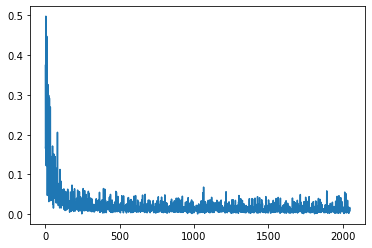

In [27]:
if __name__ == '__main__':
    train()
    validation()